<a href="https://colab.research.google.com/github/Farouk96/classification_image_deep_learning/blob/main/Copy_of_P8_01_documentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#IMPORT REQUIRED LIBRARIEs
from time import time
import numpy as np
import pandas as pd
import os
from re import search
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D,Dropout

In [5]:
!pip install tensorflow_addons
import tensorflow_addons as tfa

#Data preparation

In [6]:
#IMAGE PATH & DATAFRAME:
TRAIN_PATH = "/content/drive/MyDrive/ P8_kaggle_competition/train_images"
train_df = pd.read_csv("/content/drive/MyDrive/ P8_kaggle_competition/train.csv",sep=',')
train_df

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex
...,...,...
18627,fffb900a92289a33.jpg,healthy
18628,fffc488fa4c0e80c.jpg,scab
18629,fffc94e092a59086.jpg,rust
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot


In [7]:
from os import listdir
from os.path import isfile, join

monRepertoire='/content/drive/MyDrive/ P8_kaggle_competition/train_images'
fichiers = [f for f in listdir(monRepertoire) if isfile(join(monRepertoire, f))]
fichiers

['c04632b533bba33d.jpg',
 'c03e65db32f086cd.jpg',
 'c0377614f870c35f.jpg',
 'c05a3720fd610edf.jpg',
 'c0702f17c4f8fb45.jpg',
 'c06d02d4ca4af5df.jpg',
 'c06c7a60b360b77e.jpg',
 'c08552de599f1c2f.jpg',
 'c08364e6716477fa.jpg',
 'c0816a962dceb76b.jpg',
 'c0853d6535f2d43e.jpg',
 'c08eb5c5b7953c98.jpg',
 'c0883b8e6e2ddf29.jpg',
 'c08e2b86b5bf70a3.jpg',
 'c09798cb9eb16639.jpg',
 'c09f21a433bf3758.jpg',
 'c09e35c7d027fa16.jpg',
 'c09927d183363cdf.jpg',
 'c0983fc02e27facb.jpg',
 'c09a3f8d684f1579.jpg',
 'c0a42dfd195dd331.jpg',
 'c0c063eb2afc3ab5.jpg',
 'c0c2202b0f7f7fe4.jpg',
 'c0bc431f5396b0f5.jpg',
 'c0bd68dad79507a2.jpg',
 'c0c73614ce4ee4ed.jpg',
 'c0cb3f1b38f8e0d4.jpg',
 'c0c8679f29e519bc.jpg',
 'c0cf8b9899d591b3.jpg',
 'c0c66a37fdf58061.jpg',
 'c0df29ce91d73950.jpg',
 'c0e027301fd757ad.jpg',
 'c0d91da6b3b891cd.jpg',
 'c0df0336b4707e65.jpg',
 'c0e00e1cff8f429f.jpg',
 'c0e6e21b32cde8f4.jpg',
 'c0e1616f4d439b9b.jpg',
 'c0e18cf07d1b2de9.jpg',
 'c0f1155cba5c13fc.jpg',
 'c0ef90ea018ffb1c.jpg',


In [8]:
idx_list=[]
for i in train_df['image']:
  if i not in fichiers:
    dt= train_df[train_df['image']==i]
    train_df.drop(dt.index,axis=0,inplace=True)

In [9]:
train_df.shape

(6227, 2)

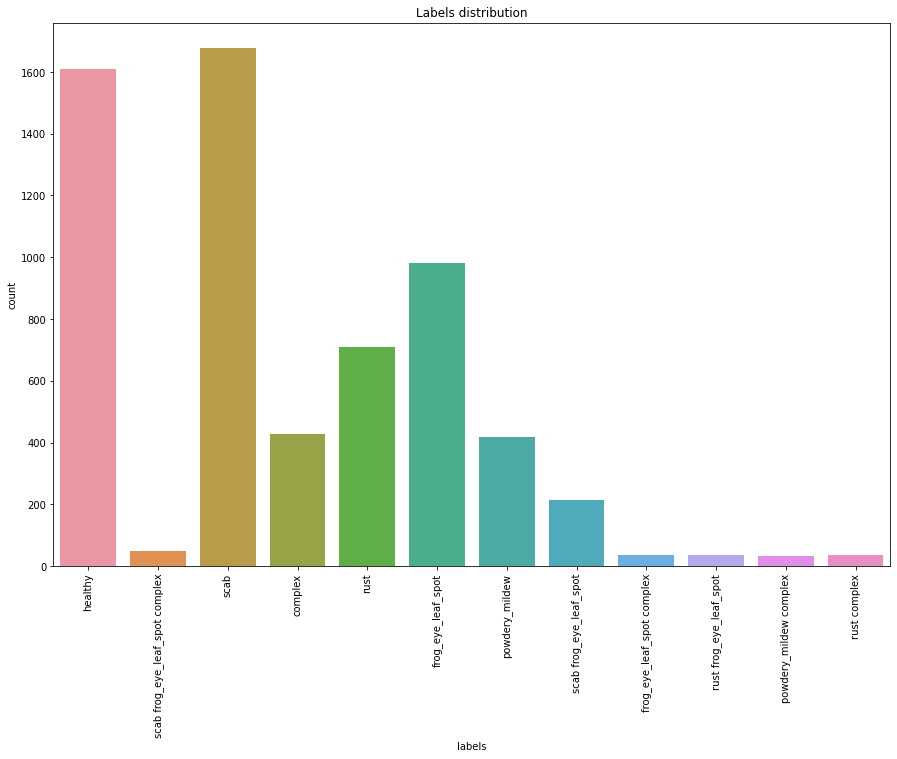

In [10]:
#Labels distribution
plt.figure(figsize=(15,10))
sns.countplot(data=train_df,x='labels')
plt.xticks(rotation=90)
plt.title('Labels distribution')
plt.show()

In [11]:
print("Number of unique labels: ",len(train_df['labels'].unique()))

Number of unique labels:  12


In [13]:
train_df['labels'].value_counts()

scab                               1676
healthy                            1610
frog_eye_leaf_spot                  980
rust                                711
complex                             429
powdery_mildew                      418
scab frog_eye_leaf_spot             214
scab frog_eye_leaf_spot complex      50
rust frog_eye_leaf_spot              36
frog_eye_leaf_spot complex           35
rust complex                         35
powdery_mildew complex               33
Name: labels, dtype: int64

In [14]:
lst_drop=['scab','healthy','frog_eye_leaf_spot','rust','complex','powdery_mildew','scab frog_eye_leaf_spot']
for i in lst_drop:
  dt=train_df[train_df['labels']==i]
  train_df.drop(dt.index[400:],axis=0,inplace=True)

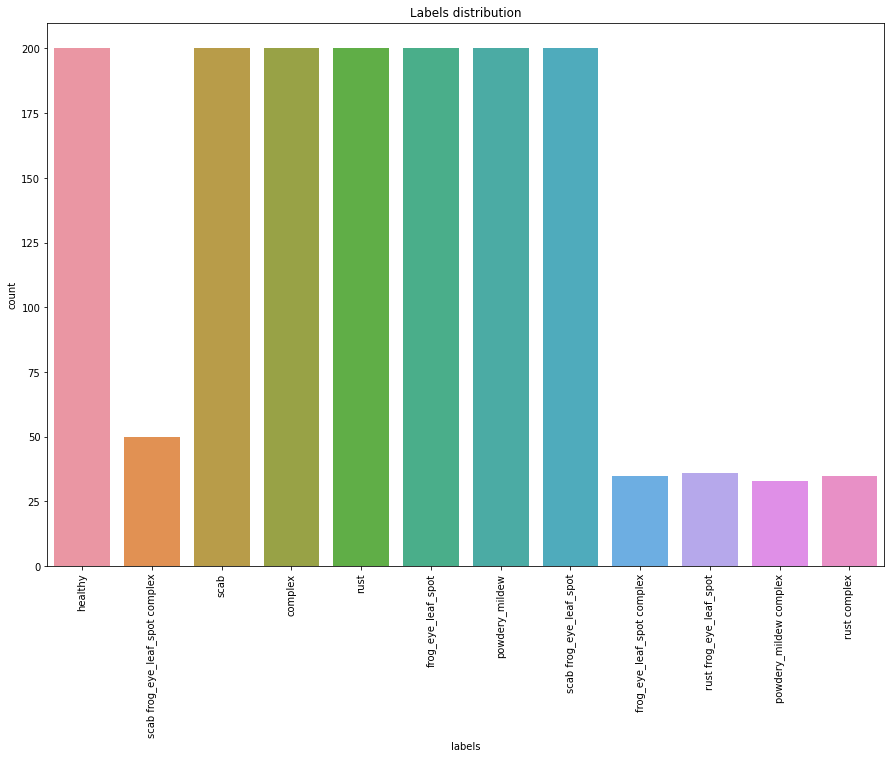

In [15]:
#Labels distribution
plt.figure(figsize=(15,10))
sns.countplot(data=train_df,x='labels')
plt.xticks(rotation=90)
plt.title('Labels distribution')
plt.show()

In [16]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split = 0.2,
    zoom_range = 0.2,
    shear_range = 0.2,
    vertical_flip = False)

In [17]:
HEIGHT = 124
WIDTH=124
SEED = 143
BATCH_SIZE=32
train_ds = train_datagen.flow_from_dataframe(
    train_df,
    directory = TRAIN_PATH,
    x_col = "image",
    y_col = "labels",
    target_size = (HEIGHT,WIDTH),
    class_mode='categorical',
    batch_size = BATCH_SIZE,
    subset = "training",
    shuffle = True,
    seed = SEED,
    validate_filenames = False)

val_ds = train_datagen.flow_from_dataframe(
    train_df,
    directory = TRAIN_PATH,
    x_col = "image",
    y_col = "labels",
    target_size = (HEIGHT,WIDTH),
    class_mode='categorical',
    batch_size = BATCH_SIZE,
    subset = "validation",
    shuffle = True,
    seed = SEED,
    validate_filenames = False
)

Found 1272 non-validated image filenames belonging to 12 classes.
Found 317 non-validated image filenames belonging to 12 classes.


#CNN from scratch

In [18]:
model=Sequential()
model.add(Conv2D(64,(3,3),activation='relu',padding='same',input_shape=(HEIGHT,WIDTH,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(12,activation='sigmoid'))

# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics = [tfa.metrics.F1Score(num_classes = 12,average = "macro",name = "f1_score")])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0

In [19]:
# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics = [tfa.metrics.F1Score(num_classes = 12,average = "macro",name = "f1_score")])

In [20]:
file_path= '/content/drive/MyDrive/ P8_kaggle_competition/Best_model_cnn.h5'

checkpoint=ModelCheckpoint(file_path,
                          monitor="val_f1_score",
                          mode='max',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor="val_f1_score",mode='max',
                       patience=5,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [21]:
t0 = time()

epochs = 60

model_history=model.fit(train_ds,validation_data=val_ds,
                                 epochs= epochs,
                                 steps_per_epoch=train_ds.samples//128,
                                 validation_steps=val_ds.samples//128,
                                 callbacks=callbacks)


print("Done in %0.3fs." % (time() - t0))

Epoch 1/60
9/9 [==============================] - ETA: 0s - loss: 2.4076 - f1_score: 0.0632 
Epoch 00001: val_f1_score improved from -inf to 0.01429, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_cnn.h5
9/9 [==============================] - 183s 21s/step - loss: 2.4076 - f1_score: 0.0632 - val_loss: 2.2987 - val_f1_score: 0.0143
Epoch 2/60
9/9 [==============================] - ETA: 0s - loss: 2.2934 - f1_score: 0.0817 
Epoch 00002: val_f1_score did not improve from 0.01429
9/9 [==============================] - 144s 16s/step - loss: 2.2934 - f1_score: 0.0817 - val_loss: 2.5163 - val_f1_score: 0.0075
Epoch 3/60
9/9 [==============================] - ETA: 0s - loss: 2.3061 - f1_score: 0.0579 
Epoch 00003: val_f1_score did not improve from 0.01429
9/9 [==============================] - 127s 14s/step - loss: 2.3061 - f1_score: 0.0579 - val_loss: 2.5884 - val_f1_score: 0.0051
Epoch 4/60
9/9 [==============================] - ETA: 0s - loss: 2.3121 - f1_score: 0.

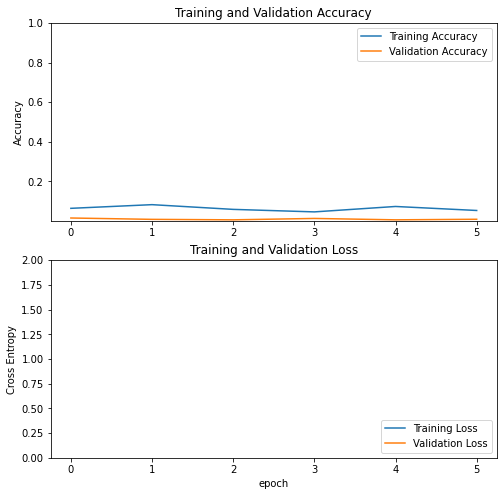

In [22]:
acc = model_history.history['f1_score']
val_acc = model_history.history['val_f1_score']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Transfer learning with inceptionV3

In [23]:
from  tensorflow.keras.applications import InceptionV3

In [24]:
#initialise base model
IMG_SHAPE = (124, 124, 3)

base_model=  InceptionV3(
    weights='imagenet',
    input_shape= IMG_SHAPE,
    include_top=False)

87924736/87910968 [==============================] - 1s 0us/step


In [25]:
base_model.trainable = False
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(320, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(12, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 320)               655680    
                                                                 
 dropout_1 (Dropout)         (None, 320)               0         
                                                                 
 dense_3 (Dense)             (None, 12)                3852      
                                                                 
Total params: 22,462,316
Trainable params: 659,532
Non-trainable params: 21,802,784
____________________________________

In [26]:
# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics = [tfa.metrics.F1Score(num_classes = 12,average = "macro",name = "f1_score")])

In [27]:
file_path= '/content/drive/MyDrive/ P8_kaggle_competition/Best_basemodel_inceptionV3.h5'

checkpoint=ModelCheckpoint(file_path,
                          monitor="val_f1_score",
                          mode='max',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor="val_f1_score",mode='max',
                       patience=5,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [28]:
t0 = time()

epochs = 20

model_history= model.fit(train_ds,validation_data=val_ds,
                         steps_per_epoch=train_ds.samples//128,
                                 validation_steps=val_ds.samples//128,
                                 epochs= epochs,
                                 callbacks=callbacks)


print("Done in %0.3fs." % (time() - t0))

Epoch 1/20
9/9 [==============================] - ETA: 0s - loss: 3.9373 - f1_score: 0.0762
Epoch 00001: val_f1_score improved from -inf to 0.03313, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_basemodel_inceptionV3.h5
9/9 [==============================] - 98s 11s/step - loss: 3.9373 - f1_score: 0.0762 - val_loss: 2.7934 - val_f1_score: 0.0331
Epoch 2/20
9/9 [==============================] - ETA: 0s - loss: 2.7207 - f1_score: 0.1609
Epoch 00002: val_f1_score improved from 0.03313 to 0.10361, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_basemodel_inceptionV3.h5
9/9 [==============================] - 79s 9s/step - loss: 2.7207 - f1_score: 0.1609 - val_loss: 2.3160 - val_f1_score: 0.1036
Epoch 3/20
9/9 [==============================] - ETA: 0s - loss: 2.3023 - f1_score: 0.1512
Epoch 00003: val_f1_score improved from 0.10361 to 0.13165, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_basemodel_inceptionV3.h5
9/9 [===========

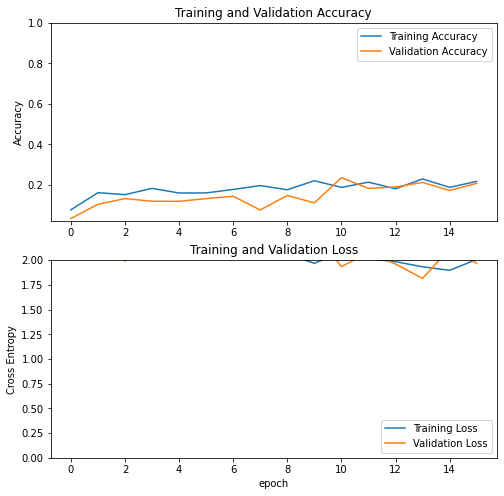

In [29]:
acc = model_history.history['f1_score']
val_acc = model_history.history['val_f1_score']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##Fine_tunning

In [30]:
base_model.trainable = True

In [31]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  311


In [32]:
fine_tune_at = 200

# Freeze all the layers before the 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [33]:
# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001/10),
    loss='categorical_crossentropy',
    metrics = [tfa.metrics.F1Score(num_classes = 12,average = "macro",name = "f1_score")])

In [34]:
file_path= '/content/drive/MyDrive/ P8_kaggle_competition/Best_model_inceptionV3.h5'

checkpoint=ModelCheckpoint(file_path,
                          monitor="val_f1_score",
                          mode='max',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor="val_f1_score",mode='max',
                       patience=5,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [35]:
t0 = time()

fine_tune_epochs = 40
total_epochs =  epochs + fine_tune_epochs

model_history_fine = model.fit(train_ds,validation_data=val_ds,
                         steps_per_epoch=train_ds.samples//128,
                                 validation_steps=val_ds.samples//128,
                                 epochs= total_epochs,
                         initial_epoch=model_history.epoch[-1],
                                 callbacks=callbacks)


print("Done in %0.3fs." % (time() - t0))

Epoch 16/60
9/9 [==============================] - ETA: 0s - loss: 2.2763 - f1_score: 0.1188
Epoch 00016: val_f1_score improved from -inf to 0.20404, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_inceptionV3.h5
9/9 [==============================] - 93s 10s/step - loss: 2.2763 - f1_score: 0.1188 - val_loss: 2.0318 - val_f1_score: 0.2040
Epoch 17/60
9/9 [==============================] - ETA: 0s - loss: 2.2398 - f1_score: 0.1060
Epoch 00017: val_f1_score did not improve from 0.20404
9/9 [==============================] - 76s 9s/step - loss: 2.2398 - f1_score: 0.1060 - val_loss: 1.9344 - val_f1_score: 0.1385
Epoch 18/60
9/9 [==============================] - ETA: 0s - loss: 2.1123 - f1_score: 0.1707
Epoch 00018: val_f1_score did not improve from 0.20404
9/9 [==============================] - 79s 9s/step - loss: 2.1123 - f1_score: 0.1707 - val_loss: 1.9160 - val_f1_score: 0.1600
Epoch 19/60
9/9 [==============================] - ETA: 0s - loss: 2.0637 - f1_score

In [36]:
acc += model_history_fine.history['f1_score']
val_acc += model_history_fine.history['val_f1_score']

loss += model_history_fine.history['loss']
val_loss += model_history_fine.history['val_loss']

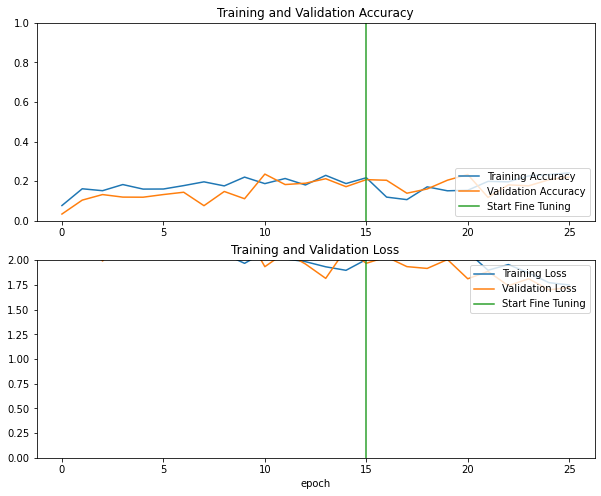

In [37]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([model_history.epoch[-1],model_history.epoch[-1]],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([model_history.epoch[-1],model_history.epoch[-1]],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Transfer learning with MobileNetV2

In [38]:
from  tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [39]:
#initialise base model
IMG_SHAPE = (124, 124, 3)

base_model=  MobileNetV2(
    weights='imagenet',
    input_shape= IMG_SHAPE,
    include_top=False)

9420800/9406464 [==============================] - 0s 0us/step


In [40]:
base_model.trainable = False
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(320, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(12, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 320)               409920    
                                                                 
 dropout_2 (Dropout)         (None, 320)               0         
                                                                 
 dense_5 (Dense)             (None, 12)                3852      
                                                                 
Total params: 2,671,756
Trainable params: 413,772
Non-

In [41]:
# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics = [tfa.metrics.F1Score(num_classes = 12,average = "macro",name = "f1_score")])

In [42]:
file_path= '/content/drive/MyDrive/ P8_kaggle_competition/Best_basemodel_mobilenetV2.h5'

checkpoint=ModelCheckpoint(file_path,
                          monitor="val_f1_score",
                          mode='max',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor="val_f1_score",mode='max',
                       patience=5,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [43]:
t0 = time()

epochs = 20

model_history= model.fit(train_ds,validation_data=val_ds,
                         steps_per_epoch=train_ds.samples//128,
                                 validation_steps=val_ds.samples//128,
                                 epochs= epochs,
                                 callbacks=callbacks)


print("Done in %0.3fs." % (time() - t0))

Epoch 1/20
9/9 [==============================] - ETA: 0s - loss: 3.0253 - f1_score: 0.1192
Epoch 00001: val_f1_score improved from -inf to 0.05619, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_basemodel_mobilenetV2.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


9/9 [==============================] - 73s 8s/step - loss: 3.0253 - f1_score: 0.1192 - val_loss: 2.0811 - val_f1_score: 0.0562
Epoch 2/20
9/9 [==============================] - ETA: 0s - loss: 2.3297 - f1_score: 0.1651
Epoch 00002: val_f1_score improved from 0.05619 to 0.17601, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_basemodel_mobilenetV2.h5
9/9 [==============================] - 60s 7s/step - loss: 2.3297 - f1_score: 0.1651 - val_loss: 2.0678 - val_f1_score: 0.1760
Epoch 3/20
9/9 [==============================] - ETA: 0s - loss: 1.9295 - f1_score: 0.2094
Epoch 00003: val_f1_score improved from 0.17601 to 0.18003, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_basemodel_mobilenetV2.h5
9/9 [==============================] - 61s 7s/step - loss: 1.9295 - f1_score: 0.2094 - val_loss: 1.8130 - val_f1_score: 0.1800
Epoch 4/20
9/9 [==============================] - ETA: 0s - loss: 1.9433 - f1_score: 0.2200
Epoch 00004: val_f1_score improved from

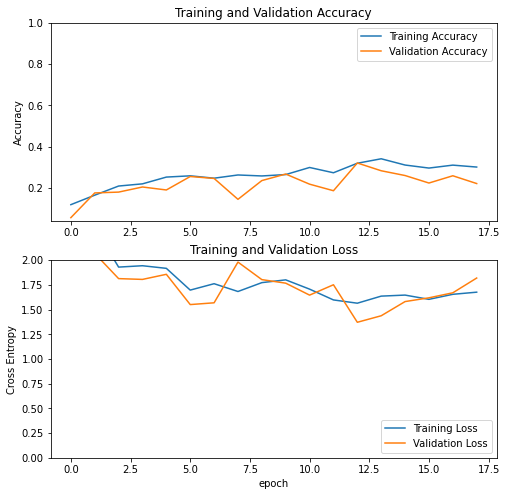

In [44]:
acc = model_history.history['f1_score']
val_acc = model_history.history['val_f1_score']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##Fine-tunning

In [45]:
base_model.trainable = True

In [46]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [47]:
fine_tune_at = 100

# Freeze all the layers before the 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [48]:
file_path= '/content/drive/MyDrive/ P8_kaggle_competition/Best_model_mobilenetV2.h5'

checkpoint=ModelCheckpoint(file_path,
                          monitor="val_f1_score",
                          mode='max',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor="val_f1_score",mode='max',
                       patience=5,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [49]:
# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics = [tfa.metrics.F1Score(num_classes = 12,average = "macro",name = "f1_score")])

In [50]:
t0 = time()

fine_tune_epochs = 40
total_epochs =  20 + fine_tune_epochs

model_history_fine = model.fit(train_ds,validation_data=val_ds,
                         steps_per_epoch=train_ds.samples//128,
                                 validation_steps=val_ds.samples//128,
                                 epochs= total_epochs,
                         initial_epoch=19, #model_history.epoch[-1],
                                 callbacks=callbacks)


print("Done in %0.3fs." % (time() - t0))

Epoch 20/60
9/9 [==============================] - ETA: 0s - loss: 2.1235 - f1_score: 0.1722
Epoch 00020: val_f1_score improved from -inf to 0.11261, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_mobilenetV2.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


9/9 [==============================] - 75s 8s/step - loss: 2.1235 - f1_score: 0.1722 - val_loss: 6.9562 - val_f1_score: 0.1126
Epoch 21/60
9/9 [==============================] - ETA: 0s - loss: 1.8609 - f1_score: 0.2422
Epoch 00021: val_f1_score did not improve from 0.11261
9/9 [==============================] - 63s 7s/step - loss: 1.8609 - f1_score: 0.2422 - val_loss: 6.4952 - val_f1_score: 0.1109
Epoch 22/60
9/9 [==============================] - ETA: 0s - loss: 1.5744 - f1_score: 0.2802
Epoch 00022: val_f1_score did not improve from 0.11261
9/9 [==============================] - 62s 7s/step - loss: 1.5744 - f1_score: 0.2802 - val_loss: 6.4455 - val_f1_score: 0.0643
Epoch 23/60
9/9 [==============================] - ETA: 0s - loss: 1.6879 - f1_score: 0.2844
Epoch 00023: val_f1_score improved from 0.11261 to 0.14835, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_mobilenetV2.h5
9/9 [==============================] - 64s 7s/step - loss: 1.6879 - f1_score: 0.28

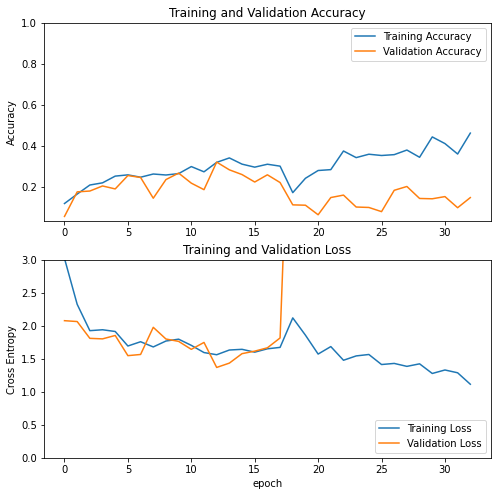

In [51]:
acc += model_history_fine.history['f1_score']
val_acc += model_history_fine.history['val_f1_score']

loss += model_history_fine.history['loss']
val_loss += model_history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Transfer learning with Resnet

In [52]:
from  tensorflow.keras.applications import ResNet101

In [53]:
#initialise base model
IMG_SHAPE = (124, 124, 3)

base_model=  ResNet101(
    weights='imagenet',
    input_shape= IMG_SHAPE,
    include_top=False)

171458560/171446536 [==============================] - 2s 0us/step


In [54]:
base_model.trainable = False
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(320, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(12, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 4, 4, 2048)        42658176  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 320)               655680    
                                                                 
 dropout_3 (Dropout)         (None, 320)               0         
                                                                 
 dense_7 (Dense)             (None, 12)                3852      
                                                                 
Total params: 43,317,708
Trainable params: 659,532
Non-trainable params: 42,658,176
____________________________________

In [55]:
# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics = [tfa.metrics.F1Score(num_classes = 12,average = "macro",name = "f1_score")])

In [56]:
file_path= '/content/drive/MyDrive/ P8_kaggle_competition/Best_basemodel_resnet101.h5'

checkpoint=ModelCheckpoint(file_path,
                          monitor="val_f1_score",
                          mode='max',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor="val_f1_score",mode='max',
                       patience=5,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [57]:
t0 = time()

epochs = 20

model_history= model.fit(train_ds,validation_data=val_ds,
                         steps_per_epoch=train_ds.samples//128,
                                 validation_steps=val_ds.samples//128,
                                 epochs= epochs,
                                 callbacks=callbacks)


print("Done in %0.3fs." % (time() - t0))

Epoch 1/20
9/9 [==============================] - ETA: 0s - loss: 2.4392 - f1_score: 0.0589
Epoch 00001: val_f1_score improved from -inf to 0.01471, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_basemodel_resnet101.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


9/9 [==============================] - 104s 11s/step - loss: 2.4392 - f1_score: 0.0589 - val_loss: 2.3896 - val_f1_score: 0.0147
Epoch 2/20
9/9 [==============================] - ETA: 0s - loss: 2.3303 - f1_score: 0.0586
Epoch 00002: val_f1_score did not improve from 0.01471
9/9 [==============================] - 84s 9s/step - loss: 2.3303 - f1_score: 0.0586 - val_loss: 2.2866 - val_f1_score: 0.0031
Epoch 3/20
9/9 [==============================] - ETA: 0s - loss: 2.2925 - f1_score: 0.0659
Epoch 00003: val_f1_score improved from 0.01471 to 0.03307, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_basemodel_resnet101.h5
9/9 [==============================] - 87s 10s/step - loss: 2.2925 - f1_score: 0.0659 - val_loss: 2.3191 - val_f1_score: 0.0331
Epoch 4/20
9/9 [==============================] - ETA: 0s - loss: 2.3039 - f1_score: 0.0719
Epoch 00004: val_f1_score did not improve from 0.03307
9/9 [==============================] - 83s 9s/step - loss: 2.3039 - f1_score: 0.

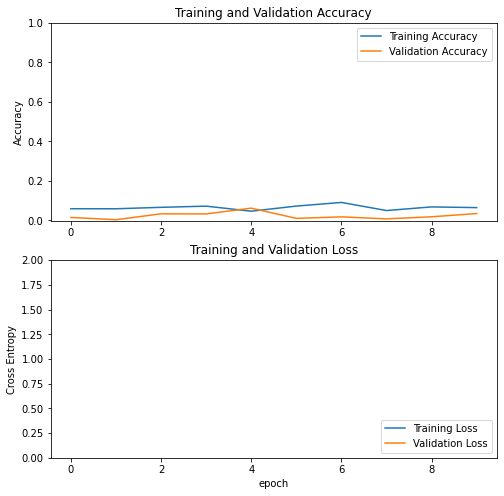

In [58]:
acc = model_history.history['f1_score']
val_acc = model_history.history['val_f1_score']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##Fine-tunning

In [59]:
base_model.trainable = True

In [60]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  345


In [61]:
fine_tune_at = 345

# Freeze all the layers before the 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [62]:
file_path= '/content/drive/MyDrive/ P8_kaggle_competition/Best_model_resnet101.h5'

checkpoint=ModelCheckpoint(file_path,
                          monitor="val_f1_score",
                          mode='max',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor="val_f1_score",mode='max',
                       patience=5,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [63]:
# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics = [tfa.metrics.F1Score(num_classes = 12,average = "macro",name = "f1_score")])

In [64]:
t0 = time()

fine_tune_epochs = 40
total_epochs =  20 + fine_tune_epochs

model_history_fine = model.fit(train_ds,validation_data=val_ds,
                         steps_per_epoch=train_ds.samples//128,
                                 validation_steps=val_ds.samples//128,
                                 epochs= total_epochs,
                         initial_epoch=model_history.epoch[-1],
                                 callbacks=callbacks)


print("Done in %0.3fs." % (time() - t0))

Epoch 10/60
9/9 [==============================] - ETA: 0s - loss: 2.3102 - f1_score: 0.0578
Epoch 00010: val_f1_score improved from -inf to 0.03865, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_resnet101.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


9/9 [==============================] - 103s 11s/step - loss: 2.3102 - f1_score: 0.0578 - val_loss: 2.4155 - val_f1_score: 0.0386
Epoch 11/60
9/9 [==============================] - ETA: 0s - loss: 2.3092 - f1_score: 0.0676
Epoch 00011: val_f1_score did not improve from 0.03865
9/9 [==============================] - 86s 9s/step - loss: 2.3092 - f1_score: 0.0676 - val_loss: 2.3567 - val_f1_score: 0.0029
Epoch 12/60
9/9 [==============================] - ETA: 0s - loss: 2.2901 - f1_score: 0.0582
Epoch 00012: val_f1_score improved from 0.03865 to 0.05028, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_resnet101.h5
9/9 [==============================] - 88s 10s/step - loss: 2.2901 - f1_score: 0.0582 - val_loss: 2.1846 - val_f1_score: 0.0503
Epoch 13/60
9/9 [==============================] - ETA: 0s - loss: 2.2895 - f1_score: 0.0579
Epoch 00013: val_f1_score did not improve from 0.05028
9/9 [==============================] - 84s 10s/step - loss: 2.2895 - f1_score: 0.

KeyboardInterrupt: ignored

In [ ]:
acc += model_history_fine.history['f1_score']
val_acc += model_history_fine.history['val_f1_score']

loss += model_history_fine.history['loss']
val_loss += model_history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Improove performances

In [ ]:
from  tensorflow.keras.applications import InceptionV3

In [ ]:
#initialise base model
IMG_SHAPE = (124, 124, 3)

base_model=  InceptionV3(
    weights='imagenet',
    input_shape= IMG_SHAPE,
    include_top=False)

In [ ]:
base_model.trainable = True
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Flatten())
#model.add(tf.keras.layers.Dense(320, activation='relu',kernel_regularizer=keras.regularizers.l1(0.001)))
#model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(12,activation='sigmoid',kernel_regularizer=keras.regularizers.l1(0.001)))

model.summary()

In [ ]:
fine_tune_at = 200

# Freeze all the layers before the 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
file_path= '/content/drive/MyDrive/ P8_kaggle_competition/Best_model_changed.h5'

checkpoint=ModelCheckpoint(file_path,
                          monitor="val_f1_score",
                          mode='max',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor="loss",mode='max',
                       patience=10,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [ ]:
# Compile the Model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics = [tfa.metrics.F1Score(num_classes = 12,average = "macro",name = "f1_score")])

In [ ]:
#drop_out=0.5
t0 = time()

epochs = 40

model_history= model.fit(train_ds,validation_data=val_ds,
                         steps_per_epoch=train_ds.samples//128,
                                 validation_steps=val_ds.samples//128,
                                 epochs= epochs,
                                 callbacks=callbacks)


print("Done in %0.3fs." % (time() - t0))

In [ ]:
acc = model_history.history['f1_score']
val_acc = model_history.history['val_f1_score']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#No drop out
t0 = time()

epochs = 40

model_history= model.fit(train_ds,validation_data=val_ds,
                         steps_per_epoch=train_ds.samples//128,
                                 validation_steps=val_ds.samples//128,
                                 epochs= epochs,
                                 callbacks=callbacks)


print("Done in %0.3fs." % (time() - t0))

In [ ]:
acc = model_history.history['f1_score']
val_acc = model_history.history['val_f1_score']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#No dense layer no dropout with flaten
t0 = time()

epochs = 40

model_history= model.fit(train_ds,validation_data=val_ds,
                         steps_per_epoch=train_ds.samples//128,
                                 validation_steps=val_ds.samples//128,
                                 epochs= epochs,
                                 callbacks=callbacks)


print("Done in %0.3fs." % (time() - t0))

In [ ]:
acc = model_history.history['f1_score']
val_acc = model_history.history['val_f1_score']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
t0 = time()

epochs = 40

model_history= model.fit(train_ds,validation_data=val_ds,
                         steps_per_epoch=train_ds.samples//128,
                                 validation_steps=val_ds.samples//128,
                                 epochs= epochs,
                                 callbacks=callbacks)


print("Done in %0.3fs." % (time() - t0))

In [ ]:
acc = model_history.history['f1_score']
val_acc = model_history.history['val_f1_score']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
t0 = time()

epochs = 40

model_history= model.fit(train_ds,validation_data=val_ds,
                         steps_per_epoch=train_ds.samples//128,
                                 validation_steps=val_ds.samples//128,
                                 epochs= epochs,
                                 callbacks=callbacks)


print("Done in %0.3fs." % (time() - t0))

In [ ]:
acc = model_history.history['f1_score']
val_acc = model_history.history['val_f1_score']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
t0 = time()

epochs = 40

model_history= model.fit(train_ds,validation_data=val_ds,
                         steps_per_epoch=train_ds.samples//128,
                                 validation_steps=val_ds.samples//128,
                                 epochs= epochs,
                                 callbacks=callbacks)


print("Done in %0.3fs." % (time() - t0))

In [ ]:
acc = model_history.history['f1_score']
val_acc = model_history.history['val_f1_score']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
train_ds.samples//256

#Evaluation performance

##CNN from scratch

In [ ]:
model.load_weights("/content/drive/MyDrive/ P8_kaggle_competition/best_model_cnn.h5")
loss, accuracy = model.evaluate(val_ds)
print('Valid accuracy :', round(accuracy, 3))
print('Valid loss :', round(loss, 3))

##InceptionV3

In [ ]:
model.load_weights("/content/drive/MyDrive/ P8_kaggle_competition/Best_model_inceptionV3.h5")
loss, accuracy = model.evaluate(val_ds)
print('Valid accuracy :', round(accuracy, 3))
print('Valid loss :', round(loss, 3))

##MobileNetV2

In [ ]:
model.load_weights("/content/drive/MyDrive/ P8_kaggle_competition/Best_model_mobilenetV2.h5")
loss, accuracy = model.evaluate(val_ds)
print('Valid accuracy :', round(accuracy, 3))
print('Valid loss :', round(loss, 3))

#SUBMISSION OF FILE

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/ P8_kaggle_competition/sample_submission.csv')
submission.head()

In [ ]:
test_datagen = ImageDataGenerator(
    rescale = 1./255
)
INPUT_SIZE = (124,124,3)
test_generator =  test_datagen.flow_from_dataframe(
    submission,
    directory="/content/drive/MyDrive/ P8_kaggle_competition/test_images",
    x_col='image',
    y_col=None,
    class_mode=None,
    target_size=INPUT_SIZE[:2]
) 

In [ ]:
preds = model.predict(test_generator)
print(preds)

In [ ]:
train_ds.class_indices

In [ ]:
def get_key(val):
    for key, value in train_ds.class_indices.items():
        if val == value:
            return key

In [ ]:
def get_preds_to_labels(preds):
    pred_lists = []
    for pred in preds:
        pred_list = []
        health = (pred>=0.4)
        
        # get healthy
        if health.sum()==0:
            label = 'healthy'
            pred_list.append(label)
            
        elif pred[2]>=0.5:
            label = 'healthy'
            pred_list.append(label)
            
        # get eles label
        else:
            for j, sub in enumerate(pred):
                if sub>=0.28:
                    label = get_key(j)
                    pred_list.append(label)
                               
        pred_lists.append(' '.join(pred_list))
    return pred_lists

In [ ]:
preds_list = get_preds_to_labels(preds)

In [ ]:
#submission['labels'] = preds_list
submission.head()

In [ ]:
submission.to_csv('/content/drive/MyDrive/ P8_kaggle_competition/submission.csv', index=False)